# 3. Classification

### Settings

檢查 `Python` 版本是否超過 3.7

In [12]:
import sys

assert sys.version_info >= (3, 7)

檢查 `Scikit-Learn` 版本是否超過 1.0.1

In [13]:
from sklearn import __version__ as sklearn_version
assert sklearn_version >= '1.2.2'

調整 `Matplotlib` 的設定

In [31]:
from pathlib import Path
import matplotlib.pyplot as plt

IMAGES_PATH = Path("images") / 'Chapter_02_end_to_end_project'
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# plt setting

params = {
   'font.size': 14,
   'axes.labelsize': 14,
   'axes.titlesize': 14,
   'legend.fontsize': 14,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
}

plt.rcParams.update(params)

In [1]:
def save_fig(figname, tight_layout=True, figext="png", resolution=300, update=False):
    full_figname = f"{figname}.{figext}"
    figpath = IMAGES_PATH / full_figname
    
    if not update and figpath.is_file():
        print(f"File '{full_figname}' already exists, use 'update=True' to overwrite")
        return
    
    if tight_layout:
        plt.tight_layout()
    plt.savefig(figpath, format=figext, dpi=resolution)

In [37]:
def plot_digit(image_data):
    plt.imshow(image_data.reshape(28, 28), cmap='binary')
    plt.axis('off')

### MNIST

當前的`sklearn.datasets`套件主要包含三類功能：

1. `fetch_*` 函數，如 `fetch_openml()`，用於下載真實生活中的資料集。
2. `load_*` 函數，用於載入 Scikit-Learn 中打包的小型示範資料集（無需從網路下載）。
3. `make_*` 函數，用於產生假資料集，常用於測試。生成的資料集通常以 (X, y) 元組形式傳回，包含輸入資料和目標，都是 NumPy 陣列。

除了假資料外，傳回的資料集都是 `sklearn.utils.Bunch` 物件，這是字典的一種，其特性是可以將 key 作為屬性進行存取。通常包含以下屬性
- `DESCR`: 資料集的描述
- `data`: 輸入資料，通常是一個2D的 `NumPy` 陣列
- `target`: 標籤，通常是一個1D的 `NumPy` 陣列

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

當你想要檢視資料集的敘述時，可以使用 `mnist.DESCR`。考慮到這個敘述可能很長，你可以使用 `textwrap` 模組，將每 120 個字元作為一行進行顯示。

In [22]:
import textwrap
print('\n'.join(map(lambda s: '\n'.join(textwrap.wrap(s, 120)), mnist.DESCR.split('\n'))))

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown
**Please cite**:

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It
can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size
image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-
world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images
from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images
contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were
centered in a 28x28 image by compu

In [23]:
X, y = mnist.data, mnist.target

In [26]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [25]:
X.shape

(70000, 784)

In [27]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [28]:
y.shape

(70000,)

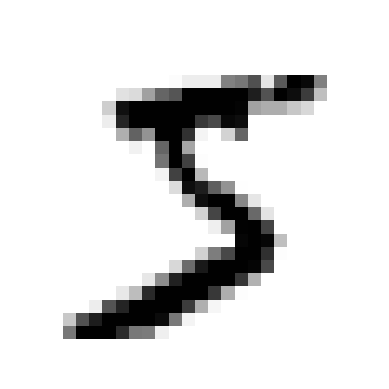

In [38]:
plot_digit(X[0])

In [39]:
y[0]

'5'

In [40]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifier

In [44]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [45]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

### Performance Measures

#### Measuring Accuracy Using Cross-Validation

一樣可以使用 `cross_val_score` 來幫助計算 CV 分數

In [47]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

或是自己手刻一個

其中 [sklearn.base.clone](https://scikit-learn.org/stable/modules/generated/sklearn.base.clone.html#sklearn.base.clone) 是用來製作分類器的深層複製，產生一個未進行過擬合的分類器。

In [48]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# didn't add `shuffle=True` because the dataset is already shuffled 
skfolds = StratifiedKFold(n_splits=3)  

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


雖然看似表現極佳，但要注意這組資料極度不平衡，隨機亂猜也會顯示出良好表現。我們可以使用 `DummyClassifier` 來進行試驗。

`DummyClassifier` 中的 `strategy` 參數有 5 種設定，分別為 `'most_frequent'`, `'prior'`, `'stratified'`, `'uniform'`, `'constant'`，預設為 `'prior'`。

- `most_frequent`：`predict`永遠傳回最常出現的類別（眾數），而 `predict_proba` 則會將最常見的類別設為 1，其他類別為 0，就像是 one-hot encoder 的編碼方式。
- `prior`：`predict`永遠傳回最常出現的類別（眾數），`predict_proba` 則會傳回每個類別在標籤中的比例（經驗先驗機率）。
- `stratified`：`predict` 會按照經驗先驗機率隨機進行抽樣。而 `predict_proba` 則會將被抽中的類別標記為 1，其他為 0。
- `uniform`：`predict` 會從每個類別中均勻地隨機選擇一個，而 `predict_proba` 則將每個類別的機率完全相等地分配。
- `constant`：`predict` 將一律傳回指定的類別，而 `predict_proba` 則將該類別的機率設為 1，其他為 0。

In [56]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


從結果來看，由於多數類別不是 5，所以 `DummyClassifier` 實際上將所有樣本都預測為 `False`。儘管如此，這樣的預測仍然呈現出 90% 的準確度。

In [58]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

#### Confusion Matrices

#### Precision and Recall

#### The Precision/Recall Trade-off

#### The ROC Curve

### Multiclass Classification

### Error Analysis

### Multilabel Classification

### Multioutput Classification